In [1]:
import pyopencl as cl
from pyopencl.elementwise import ElementwiseKernel
import pyopencl.array as cla
import pyopencl.clmath as clm
import numpy as np
import time
import soundfile
from scipy import signal as sgn
import gammatone.filters as oldfilt
import gammatonecl.filters as newfilt
from matplotlib import pyplot as plt
from tqdm import tqdm

ctx = cl.create_some_context()
q = cl.CommandQueue(ctx)

In [102]:
power = cl.Program(ctx, """
__kernel void clpow(__global float *x, const float y){
    int gid = get_global_id(0);
    x[gid] = pow(x[gid], y);
}
""").build()

x = np.arange(0, 20, dtype=np.float32)
x_g = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, x.nbytes)
cl.enqueue_copy(q, x_g, x)
powpow = power.clpow
powpow.set_scalar_arg_dtypes([None, np.float32])
powpow(q, x.shape, None, x_g, 3)
result = np.empty_like(x)
cl.enqueue_copy(q, result, x_g)
print(result)

[0.0000000e+00 1.0000000e+00 8.0000000e+00 2.7000000e+01 6.4000000e+01
 1.2500000e+02 2.1600000e+02 3.4300000e+02 5.1200000e+02 7.2900006e+02
 9.9999994e+02 1.3310000e+03 1.7280000e+03 2.1970000e+03 2.7440000e+03
 3.3750002e+03 4.0960000e+03 4.9130000e+03 5.8320000e+03 6.8590000e+03]


In [14]:
filts = oldfilt.make_erb_filters(44100, oldfilt.centre_freqs(44100, 50, 20))
wave, fs = soundfile.read('04 Traffic and Weather.flac')

t = np.linspace(-1, 1, 201)
x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +
      0.1*np.sin(2*np.pi*1.25*t + 1) +
      0.18*np.cos(2*np.pi*3.85*t))

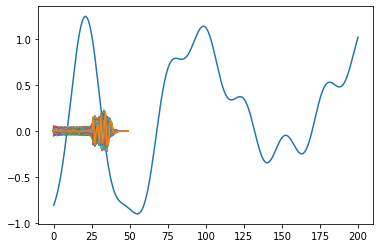

In [5]:
wavem = np.mean(wave, axis=1)

In [6]:
y = sgn.lfilter(b, a, wave)
y.shape

(9557352, 2)

In [7]:
test_wave = wave[:, 0]

In [8]:
y_m = []
N = 50
for i, v in tqdm(enumerate(test_wave), total=len(test_wave)):
    window = test_wave[i:i+N]
    if len(window) < N:
        window = np.pad(window, (0, N - len(window)))
    tar_x = window
    y_m.append(np.sum(tar_x * b))

100%|██████████| 9557352/9557352 [00:53<00:00, 177544.34it/s]


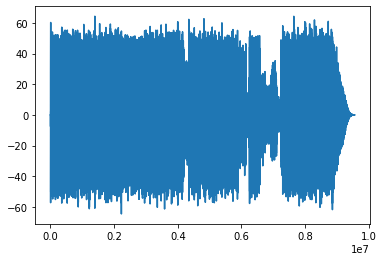

In [92]:
plt.plot(y_m)

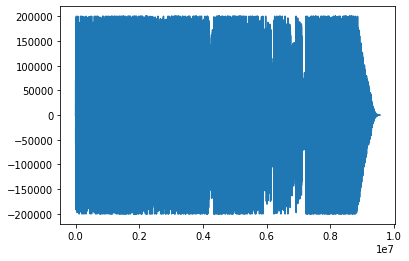

In [94]:
plt.plot(y[:, 1])

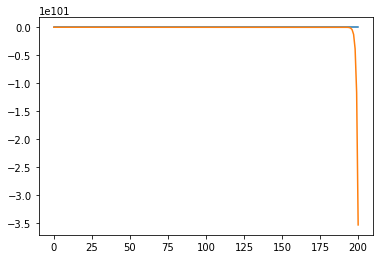